# Проблема мошеннических операций

Мошенничество существует с тех пор, как существует человечество, и может принимать бесконечное множество различных форм. Кроме того, развитие новых технологий предоставляет преступникам дополнительные способы совершения мошенничества, например, в электронной коммерции

Использование кредитных карт широко распространено в современном обществе, и мошенничество с кредитными картами неуклонно растет в последние годы. Финансовые потери из-за мошенничества затрагивают не только банки, но и отдельных клиентов. Если банк теряет деньги, клиенты в конечном итоге тоже платят через более высокие процентные ставки, повышенные членские взносы и т.д.

Обнаружение мошенничества — это процесс определения, принадлежит ли новая авторизованная транзакция к мошенническим или подлинным транзакциям, исходя из набора кредитных карт транзакций. Система обнаружения мошенничества (FDS) должна не только эффективно выявлять случаи мошенничества, но и быть экономически эффективной в том смысле, что стоимость, затрачиваемая на проверку транзакций, не должна превышать потери от мошенничества.

Техники машинного обучения базируются на выводе модели предсказания на основе набора примеров. Эта модель, чаще всего параметрическая функция, позволяет предсказывать вероятность того, что транзакция является мошенничеством, на основе набора характеристик, описывающих транзакцию. В области обнаружения мошенничества использование техник обучения привлекательно по ряду причин. 

1. Они позволяют обнаруживать закономерности в данных с высокой размерностью, т.е. транзакции поступают в виде непрерывного потока и каждая транзакция определяется многими переменными.
2. Мошеннические транзакции часто коррелируют во времени и пространстве. Например, мошенники обычно пытаются совершить аферы в одном магазине с разными картами в течение короткого периода времени.
3. Методы обучения могут использоваться для обнаружения и моделирования существующих мошеннических стратегий, а также для выявления новых стратегий, связанных с необычным поведением владельцев карт.

Предсказательные модели, основанные на методах ML, также способны автоматически интегрировать обратную связь следователей для улучшения точности обнаружения, в то время как в случае экспертных систем включение обратной связи требует пересмотра правил, что может быть утомительным и трудоемким.


# О наборе данных 

Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт. Он содержит только числовые входные переменные, которые являются результатом преобразования PCA.

Он содержит 31 числовую входную переменную. Признак `Time` обозначает количество секунд, прошедших между каждой транзакцией и первой транзакцией в наборе данных. Признак `Amount` — сумма транзакции, которая может использоваться, например, в задачах обучения с учетом затрат.

Признак `Class` является целевой переменной и принимает значение 1 при мошенничестве и 0 — в противном случае.

Набор данных сильно несбалансирован: мошенничество составляет 0,172% от всех транзакций (492 мошеннические транзакции из 284 807). Также отсутствует идентификатор владельца карты, поэтому каждую транзакцию можно рассматривать как независимую от остальных.

Из-за дисбаланса классов наши модели классификации будут считать, что в большинстве случаев мошенничество отсутствует! Нам нужно, чтобы модель была уверена при выявлении мошенничества. Чтобы избежать переобучения мы будем использовать подвыборки для обучения модели. В этом случае наша подвыборка будет датафреймом с соотношением 50/50 мошеннических и немошеннических транзакций.

То есть будем использовать деление набора на train | test при помощи Кросс-Валидаций для того, чтобы избежать дисбаланса классов и обучать модели на подвыборках 50/50


### Импорт библиотек

In [1]:
import warnings, os, json, math, sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/creditcard.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [105]:
df.corr()["Class"].sort_values()

V17      -0.326524
V14      -0.302600
V12      -0.260637
V10      -0.216982
V16      -0.196675
V3       -0.193445
V7       -0.190716
V18      -0.111498
V1       -0.101533
V9       -0.097737
V5       -0.096216
V6       -0.043872
Time     -0.012323
V24      -0.007220
V13      -0.004568
V15      -0.004222
V23      -0.002700
V22       0.000803
V25       0.003308
V26       0.004456
Amount    0.005905
V28       0.009572
V27       0.017786
V8        0.019890
V20       0.020459
V19       0.034793
V21       0.040510
V2        0.091789
V4        0.133546
V11       0.154889
Class     1.000000
Name: Class, dtype: float64

In [9]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

D:\anaconda\envs\ml_course\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='count'>

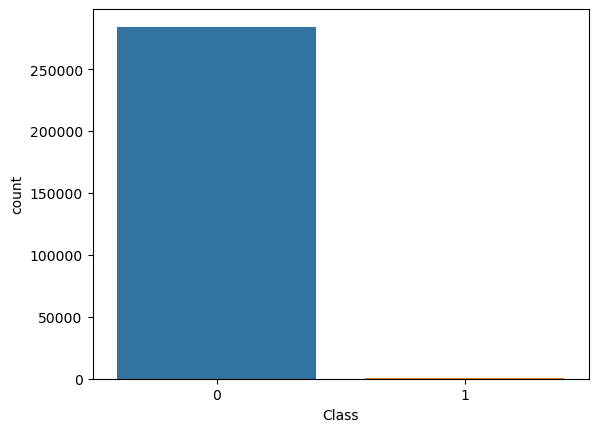

In [104]:
sns.countplot('Class', data=df)

При несбалансированном датафрейме мы не можем увидеть истинные корреляции между классом и признаками.

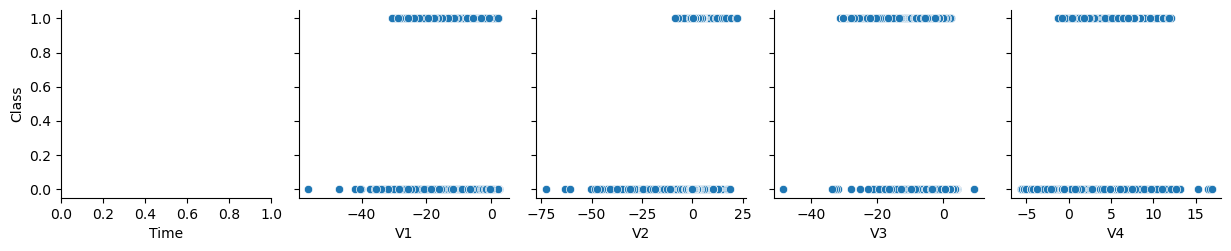

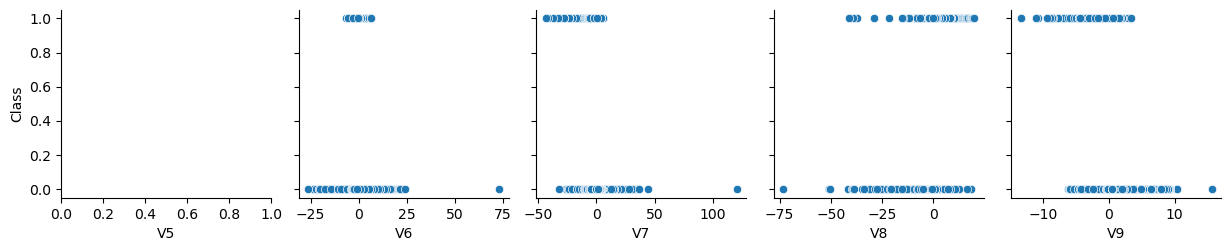

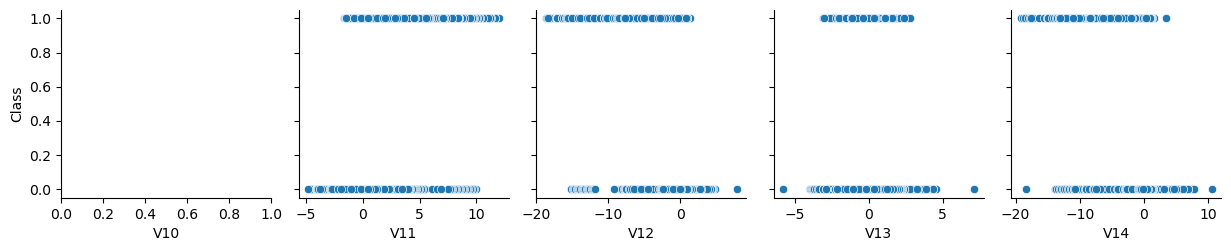

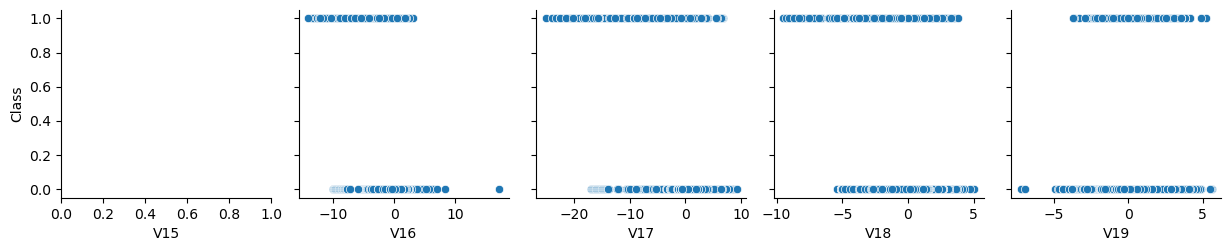

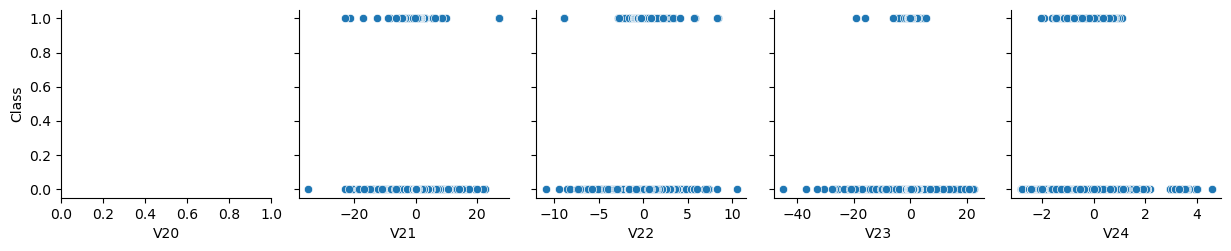

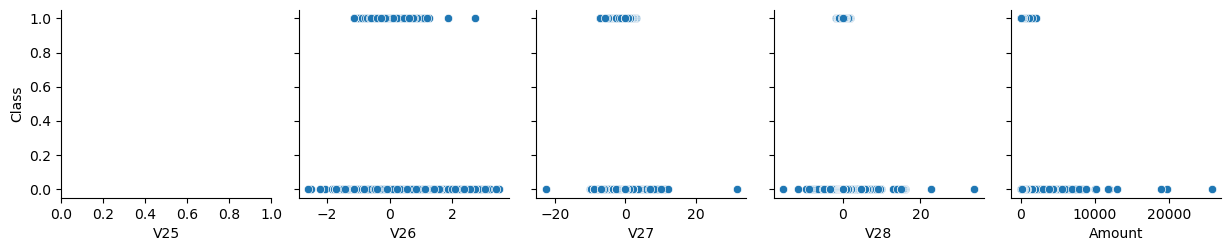

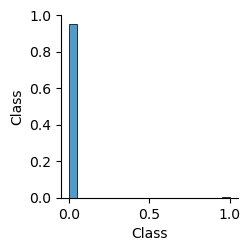

In [80]:
df_num = df.select_dtypes(exclude='object')
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['Class'])

In [81]:
df[df['V7'] > 50 ]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.34736,-3.872425,...,-21.62012,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0


In [82]:
df[df['V6'] > 50 ]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.34736,-3.872425,...,-21.62012,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0


In [83]:
df[df['V27'] > 20 ]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.34736,-3.872425,...,-21.62012,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0


Так как операция 274771 очень сильно отклоняется от данных, то следует ее удалить для точность прогнозирования

In [85]:
df.drop(274771, inplace=True)

Text(0, 0.5, 'Class')

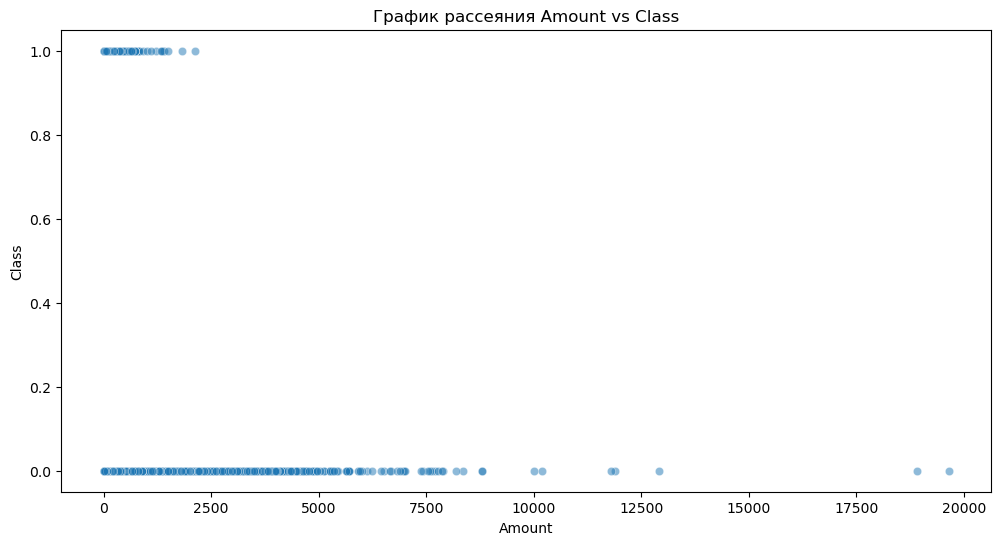

In [98]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Amount', y='Class', alpha=0.5)
plt.title('График рассеяния Amount vs Class')
plt.xlabel('Amount')
plt.ylabel('Class')

In [90]:
df["Amount"].describe()

count    284806.000000
mean         88.259724
std         245.476460
min           0.000000
25%           5.600000
50%          22.000000
75%          77.160000
max       19656.530000
Name: Amount, dtype: float64